# Train quantization table for a specific image

In [13]:
%reload_ext autoreload
%autoreload 2

In [7]:
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from helpers import utils, tf_helpers
utils.setup_logging()
tf_helpers.print_versions()

Tensorflow: 2.1.2
GPUs: []


In [8]:
from helpers import dataset, plots, image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from helpers import utils, tf_helpers
from skimage.measure import compare_ssim, compare_psnr
from models import jpeg
from models.layers import Quantization

In [68]:
import random

utils.setup_logging()
random.seed(1)
data = dataset.Dataset('data/diff_jpeg/image1', n_images=1, v_images=0, val_n_patches=1, load='y')


np.random.seed(1)
batch_rgb = data.next_training_batch(0, 1, 64)


codec_differentiable = jpeg.JPEG(50, codec='soft', trainable=True)
codec_differentiable._model.quantization = Quantization(codec_differentiable._model.rounding_approximation, codec_differentiable._model.rounding_approximation_steps, latent_bpf=9)
luma, chroma = codec_differentiable.train_q_table(batch_rgb, alpha=1, beta=100, n_times=20)

23:02:20 | DEBUG | data/diff_jpeg/image1: in total 1 files available
Loading images: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.43it/s]
Loading patches (flat-aggressive): 0it [00:00, ?it/s]


quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 16.,  11.,  10.,  16.,  24.,  40.,  51.,  61.],
       [ 12.,  12.,  14.,  19.,  26.,  58.,  60.,  55.],
       [ 14.,  13.,  16.,  24.,  40.,  57.,  69.,  56.],
       [ 14.,  17.,  22.,  29.,  51.,  87.,  80.,  62.],
       [ 18.,  22.,  37.,  56.,  68., 109., 103.,  77.],
       [ 24.,  35.,  55.,  64.,  81., 104., 113.,  92.],
       [ 49.,  64.,  78.,  87., 103., 121., 120., 101.],
       [ 72.,  92.,  95.,  98., 112., 100., 103.,  99.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[17., 18., 24., 47., 99., 99., 99., 99.],
       [18., 21., 26., 66., 99., 99., 99., 99.],
       [24., 26., 56., 99., 99., 99., 99., 99.],
       [47., 66., 99., 99., 99., 99., 99., 99.],
       [99., 99., 99., 99., 99., 99., 99., 99.],
       [99., 99., 99., 99., 99., 99., 99., 99.],
       [99., 99., 99., 99., 99., 99., 99., 99.],
       [99., 99., 99., 99

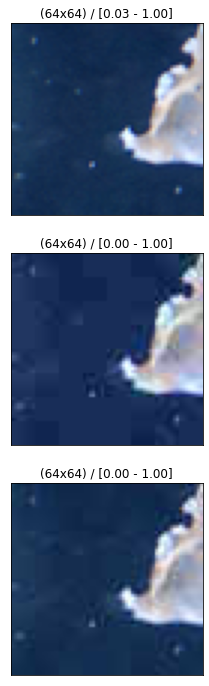

In [97]:
batch_compressed, Z, entropy_code = codec_differentiable.process(batch_rgb, return_entropy=True)
codec_libjpeg = jpeg.JPEG(50, 'libjpeg')
batch_libjpeg = codec_libjpeg.process(batch_rgb)

plots.images(image.cati(batch_rgb, batch_compressed, batch_libjpeg), '{}', ncols=-2)

# Compare diffjpeg with standard jpeg and gueztli

In [69]:
from compression.ratedistortion import get_jpeg_df, get_diff_jpeg_df, get_jpeg_imagemagick_df

In [83]:
get_diff_jpeg_df(directory="data/diff_jpeg/image1", effective_bytes=False)

23:29:46 | DEBUG | data/diff_jpeg/image1: in total 1 files available
Loading images: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s]
23:29:48 | DEBUG | data/diff_jpeg/image1: in total 1 files available
Loading images: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.42it/s]
Loading patches (flat-aggressive): 0it [00:00, ?it/s]
JPEG:   0%|                                                                                      | 0/18 [00:00<?, ?it/s]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 2.,  1.,  1.,  2.,  2.,  4.,  5.,  6.],
       [ 1.,  1.,  1.,  2.,  3.,  6.,  6.,  6.],
       [ 1.,  1.,  2.,  2.,  4.,  6.,  7.,  6.],
       [ 1.,  2.,  2.,  3.,  5.,  9.,  8.,  6.],
       [ 2.,  2.,  4.,  6.,  7., 11., 10.,  8.],
       [ 2.,  4.,  6.,  6.,  8., 10., 11.,  9.],
       [ 5.,  6.,  8.,  9., 10., 12., 12., 10.],
       [ 7.,  9., 10., 10., 11., 10., 10., 10.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 2.,  2.,  2.,  5., 10., 10., 10., 10.],
       [ 2.,  2.,  3.,  7., 10., 10., 10., 10.],
       [ 2.,  3.,  6., 10., 10., 10., 10., 10.],
       [ 5.,  7., 10., 10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10., 10., 10., 10.]], dtype=float32)>
000 --> 0.96 3.96 3.96 

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:   6%|███                                                   | 1/18 [00:17<05:00, 17.65s/it, image_id=0, quality=95]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 3.,  2.,  2.,  3.,  5.,  8., 10., 12.],
       [ 2.,  2.,  3.,  4.,  5., 12., 12., 11.],
       [ 3.,  3.,  3.,  5.,  8., 11., 14., 11.],
       [ 3.,  3.,  4.,  6., 10., 17., 16., 12.],
       [ 4.,  4.,  7., 11., 14., 22., 21., 15.],
       [ 5.,  7., 11., 13., 16., 21., 23., 18.],
       [10., 13., 16., 17., 21., 24., 24., 20.],
       [14., 18., 19., 20., 22., 20., 21., 20.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 3.,  4.,  5.,  9., 20., 20., 20., 20.],
       [ 4.,  4.,  5., 13., 20., 20., 20., 20.],
       [ 5.,  5., 11., 20., 20., 20., 20., 20.],
       [ 9., 13., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20.]], dtype=float32)>
000 --> 0.95 6.72 6.72 

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  11%|██████                                                | 2/18 [00:31<04:24, 16.54s/it, image_id=0, quality=90]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 5.,  3.,  3.,  5.,  7., 12., 15., 18.],
       [ 4.,  4.,  4.,  6.,  8., 17., 18., 17.],
       [ 4.,  4.,  5.,  7., 12., 17., 21., 17.],
       [ 4.,  5.,  7.,  9., 15., 26., 24., 19.],
       [ 5.,  7., 11., 17., 20., 33., 31., 23.],
       [ 7., 11., 17., 19., 24., 31., 34., 28.],
       [15., 19., 23., 26., 31., 36., 36., 30.],
       [22., 28., 29., 29., 34., 30., 31., 30.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 5.,  5.,  7., 14., 30., 30., 30., 30.],
       [ 5.,  6.,  8., 20., 30., 30., 30., 30.],
       [ 7.,  8., 17., 30., 30., 30., 30., 30.],
       [14., 20., 30., 30., 30., 30., 30., 30.],
       [30., 30., 30., 30., 30., 30., 30., 30.],
       [30., 30., 30., 30., 30., 30., 30., 30.],
       [30., 30., 30., 30., 30., 30., 30., 30.],
       [30., 30., 30., 30., 30., 30., 30., 30.]], dtype=float32)>
000 --> 0.94 9.26 9.26 

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  17%|█████████                                             | 3/18 [00:47<04:04, 16.29s/it, image_id=0, quality=85]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 6.,  4.,  4.,  6., 10., 16., 20., 24.],
       [ 5.,  5.,  6.,  8., 10., 23., 24., 22.],
       [ 6.,  5.,  6., 10., 16., 23., 28., 22.],
       [ 6.,  7.,  9., 12., 20., 35., 32., 25.],
       [ 7.,  9., 15., 22., 27., 44., 41., 31.],
       [10., 14., 22., 26., 32., 42., 45., 37.],
       [20., 26., 31., 35., 41., 48., 48., 40.],
       [29., 37., 38., 39., 45., 40., 41., 40.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 7.,  7., 10., 19., 40., 40., 40., 40.],
       [ 7.,  8., 10., 26., 40., 40., 40., 40.],
       [10., 10., 22., 40., 40., 40., 40., 40.],
       [19., 26., 40., 40., 40., 40., 40., 40.],
       [40., 40., 40., 40., 40., 40., 40., 40.],
       [40., 40., 40., 40., 40., 40., 40., 40.],
       [40., 40., 40., 40., 40., 40., 40., 40.],
       [40., 40., 40., 40., 40., 40., 40., 40.]], dtype=float32)>
000 --> 0.93 10.75 10.7

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  22%|████████████                                          | 4/18 [01:01<03:37, 15.52s/it, image_id=0, quality=80]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 8.,  6.,  5.,  8., 12., 20., 26., 31.],
       [ 6.,  6.,  7., 10., 13., 29., 30., 28.],
       [ 7.,  7.,  8., 12., 20., 29., 35., 28.],
       [ 7.,  9., 11., 15., 26., 44., 40., 31.],
       [ 9., 11., 19., 28., 34., 55., 52., 39.],
       [12., 18., 28., 32., 41., 52., 57., 46.],
       [25., 32., 39., 44., 52., 61., 60., 51.],
       [36., 46., 48., 49., 56., 50., 52., 50.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 9.,  9., 12., 24., 50., 50., 50., 50.],
       [ 9., 11., 13., 33., 50., 50., 50., 50.],
       [12., 13., 28., 50., 50., 50., 50., 50.],
       [24., 33., 50., 50., 50., 50., 50., 50.],
       [50., 50., 50., 50., 50., 50., 50., 50.],
       [50., 50., 50., 50., 50., 50., 50., 50.],
       [50., 50., 50., 50., 50., 50., 50., 50.],
       [50., 50., 50., 50., 50., 50., 50., 50.]], dtype=float32)>
000 --> 0.93 12.08 12.0

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  28%|███████████████                                       | 5/18 [01:14<03:14, 14.96s/it, image_id=0, quality=75]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[10.,  7.,  6., 10., 14., 24., 31., 37.],
       [ 7.,  7.,  8., 11., 16., 35., 36., 33.],
       [ 8.,  8., 10., 14., 24., 34., 41., 34.],
       [ 8., 10., 13., 17., 31., 52., 48., 37.],
       [11., 13., 22., 34., 41., 65., 62., 46.],
       [14., 21., 33., 38., 49., 62., 68., 55.],
       [29., 38., 47., 52., 62., 73., 72., 61.],
       [43., 55., 57., 59., 67., 60., 62., 59.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[10., 11., 14., 28., 59., 59., 59., 59.],
       [11., 13., 16., 40., 59., 59., 59., 59.],
       [14., 16., 34., 59., 59., 59., 59., 59.],
       [28., 40., 59., 59., 59., 59., 59., 59.],
       [59., 59., 59., 59., 59., 59., 59., 59.],
       [59., 59., 59., 59., 59., 59., 59., 59.],
       [59., 59., 59., 59., 59., 59., 59., 59.],
       [59., 59., 59., 59., 59., 59., 59., 59.]], dtype=float32)>
000 --> 0.92 12.96 12.9

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  33%|██████████████████                                    | 6/18 [01:33<03:13, 16.10s/it, image_id=0, quality=70]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[11.,  8.,  7., 11., 17., 28., 36., 43.],
       [ 8.,  8., 10., 13., 18., 41., 42., 39.],
       [10.,  9., 11., 17., 28., 40., 48., 39.],
       [10., 12., 15., 20., 36., 61., 56., 43.],
       [13., 15., 26., 39., 48., 76., 72., 54.],
       [17., 25., 39., 45., 57., 73., 79., 64.],
       [34., 45., 55., 61., 72., 85., 84., 71.],
       [50., 64., 67., 69., 78., 70., 72., 69.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[12., 13., 17., 33., 69., 69., 69., 69.],
       [13., 15., 18., 46., 69., 69., 69., 69.],
       [17., 18., 39., 69., 69., 69., 69., 69.],
       [33., 46., 69., 69., 69., 69., 69., 69.],
       [69., 69., 69., 69., 69., 69., 69., 69.],
       [69., 69., 69., 69., 69., 69., 69., 69.],
       [69., 69., 69., 69., 69., 69., 69., 69.],
       [69., 69., 69., 69., 69., 69., 69., 69.]], dtype=float32)>
000 --> 0.91 14.52 14.5

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  39%|█████████████████████                                 | 7/18 [01:50<02:58, 16.24s/it, image_id=0, quality=65]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[13.,  9.,  8., 13., 19., 32., 41., 49.],
       [10., 10., 11., 15., 21., 46., 48., 44.],
       [11., 10., 13., 19., 32., 46., 55., 45.],
       [11., 14., 18., 23., 41., 70., 64., 50.],
       [14., 18., 30., 45., 54., 87., 82., 62.],
       [19., 28., 44., 51., 65., 83., 90., 74.],
       [39., 51., 62., 70., 82., 97., 96., 81.],
       [58., 74., 76., 78., 90., 80., 82., 79.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[14., 14., 19., 38., 79., 79., 79., 79.],
       [14., 17., 21., 53., 79., 79., 79., 79.],
       [19., 21., 45., 79., 79., 79., 79., 79.],
       [38., 53., 79., 79., 79., 79., 79., 79.],
       [79., 79., 79., 79., 79., 79., 79., 79.],
       [79., 79., 79., 79., 79., 79., 79., 79.],
       [79., 79., 79., 79., 79., 79., 79., 79.],
       [79., 79., 79., 79., 79., 79., 79., 79.]], dtype=float32)>
000 --> 0.91 15.59 15.5

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  44%|████████████████████████                              | 8/18 [02:03<02:34, 15.47s/it, image_id=0, quality=60]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 14.,  10.,   9.,  14.,  22.,  36.,  46.,  55.],
       [ 11.,  11.,  13.,  17.,  23.,  52.,  54.,  50.],
       [ 13.,  12.,  14.,  22.,  36.,  51.,  62.,  50.],
       [ 13.,  15.,  20.,  26.,  46.,  78.,  72.,  56.],
       [ 16.,  20.,  33.,  50.,  61.,  98.,  93.,  69.],
       [ 22.,  32.,  50.,  58.,  73.,  94., 102.,  83.],
       [ 44.,  58.,  70.,  78.,  93., 109., 108.,  91.],
       [ 65.,  83.,  86.,  88., 101.,  90.,  93.,  89.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[15., 16., 22., 42., 89., 89., 89., 89.],
       [16., 19., 23., 59., 89., 89., 89., 89.],
       [22., 23., 50., 89., 89., 89., 89., 89.],
       [42., 59., 89., 89., 89., 89., 89., 89.],
       [89., 89., 89., 89., 89., 89., 89., 89.],
       [89., 89., 89., 89., 89., 89., 89., 89.],
       [89., 89., 89., 89., 89., 89., 89., 89.],
       [89., 89., 89., 89

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  50%|███████████████████████████                           | 9/18 [02:17<02:14, 14.95s/it, image_id=0, quality=55]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 16.,  11.,  10.,  16.,  24.,  40.,  51.,  61.],
       [ 12.,  12.,  14.,  19.,  26.,  58.,  60.,  55.],
       [ 14.,  13.,  16.,  24.,  40.,  57.,  69.,  56.],
       [ 14.,  17.,  22.,  29.,  51.,  87.,  80.,  62.],
       [ 18.,  22.,  37.,  56.,  68., 109., 103.,  77.],
       [ 24.,  35.,  55.,  64.,  81., 104., 113.,  92.],
       [ 49.,  64.,  78.,  87., 103., 121., 120., 101.],
       [ 72.,  92.,  95.,  98., 112., 100., 103.,  99.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[17., 18., 24., 47., 99., 99., 99., 99.],
       [18., 21., 26., 66., 99., 99., 99., 99.],
       [24., 26., 56., 99., 99., 99., 99., 99.],
       [47., 66., 99., 99., 99., 99., 99., 99.],
       [99., 99., 99., 99., 99., 99., 99., 99.],
       [99., 99., 99., 99., 99., 99., 99., 99.],
       [99., 99., 99., 99., 99., 99., 99., 99.],
       [99., 99., 99., 99

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  56%|█████████████████████████████▍                       | 10/18 [02:30<01:56, 14.51s/it, image_id=0, quality=50]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 18.,  12.,  11.,  18.,  27.,  44.,  57.,  68.],
       [ 13.,  13.,  16.,  21.,  29.,  64.,  67.,  61.],
       [ 16.,  14.,  18.,  27.,  44.,  63.,  77.,  62.],
       [ 16.,  19.,  24.,  32.,  57.,  97.,  89.,  69.],
       [ 20.,  24.,  41.,  62.,  76., 121., 114.,  86.],
       [ 27.,  39.,  61.,  71.,  90., 116., 126., 102.],
       [ 54.,  71.,  87.,  97., 114., 134., 133., 112.],
       [ 80., 102., 106., 109., 124., 111., 114., 110.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 19.,  20.,  27.,  52., 110., 110., 110., 110.],
       [ 20.,  23.,  29.,  73., 110., 110., 110., 110.],
       [ 27.,  29.,  62., 110., 110., 110., 110., 110.],
       [ 52.,  73., 110., 110., 110., 110., 110., 110.],
       [110., 110., 110., 110., 110., 110., 110., 110.],
       [110., 110., 110., 110., 110., 110., 110., 110.],
       [110., 110., 110., 

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  61%|████████████████████████████████▍                    | 11/18 [02:45<01:41, 14.46s/it, image_id=0, quality=45]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 20.,  14.,  13.,  20.,  30.,  50.,  64.,  76.],
       [ 15.,  15.,  18.,  24.,  33.,  73.,  75.,  69.],
       [ 18.,  16.,  20.,  30.,  50.,  71.,  86.,  70.],
       [ 18.,  21.,  28.,  36.,  64., 109., 100.,  78.],
       [ 23.,  28.,  46.,  70.,  85., 136., 129.,  96.],
       [ 30.,  44.,  69.,  80., 101., 130., 141., 115.],
       [ 61.,  80.,  98., 109., 129., 151., 150., 126.],
       [ 90., 115., 119., 123., 140., 125., 129., 124.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 21.,  23.,  30.,  59., 124., 124., 124., 124.],
       [ 23.,  26.,  33.,  83., 124., 124., 124., 124.],
       [ 30.,  33.,  70., 124., 124., 124., 124., 124.],
       [ 59.,  83., 124., 124., 124., 124., 124., 124.],
       [124., 124., 124., 124., 124., 124., 124., 124.],
       [124., 124., 124., 124., 124., 124., 124., 124.],
       [124., 124., 124., 

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  67%|███████████████████████████████████▎                 | 12/18 [02:58<01:25, 14.24s/it, image_id=0, quality=40]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 23.,  16.,  14.,  23.,  34.,  57.,  73.,  87.],
       [ 17.,  17.,  20.,  27.,  37.,  83.,  86.,  79.],
       [ 20.,  19.,  23.,  34.,  57.,  81.,  99.,  80.],
       [ 20.,  24.,  31.,  41.,  73., 124., 114.,  89.],
       [ 26.,  31.,  53.,  80.,  97., 156., 147., 110.],
       [ 34.,  50.,  79.,  91., 116., 149., 161., 131.],
       [ 70.,  91., 111., 124., 147., 173., 171., 144.],
       [103., 131., 136., 140., 160., 143., 147., 141.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 24.,  26.,  34.,  67., 141., 141., 141., 141.],
       [ 26.,  30.,  37.,  94., 141., 141., 141., 141.],
       [ 34.,  37.,  80., 141., 141., 141., 141., 141.],
       [ 67.,  94., 141., 141., 141., 141., 141., 141.],
       [141., 141., 141., 141., 141., 141., 141., 141.],
       [141., 141., 141., 141., 141., 141., 141., 141.],
       [141., 141., 141., 

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  72%|██████████████████████████████████████▎              | 13/18 [03:12<01:09, 13.98s/it, image_id=0, quality=35]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 27.,  18.,  17.,  27.,  40.,  67.,  85., 102.],
       [ 20.,  20.,  23.,  32.,  43.,  97., 100.,  92.],
       [ 23.,  22.,  27.,  40.,  67.,  95., 115.,  93.],
       [ 23.,  28.,  37.,  48.,  85., 145., 133., 103.],
       [ 30.,  37.,  62.,  93., 113., 182., 172., 128.],
       [ 40.,  58.,  92., 107., 135., 173., 188., 153.],
       [ 82., 107., 130., 145., 172., 202., 200., 168.],
       [120., 153., 158., 163., 187., 167., 172., 165.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 28.,  30.,  40.,  78., 165., 165., 165., 165.],
       [ 30.,  35.,  43., 110., 165., 165., 165., 165.],
       [ 40.,  43.,  93., 165., 165., 165., 165., 165.],
       [ 78., 110., 165., 165., 165., 165., 165., 165.],
       [165., 165., 165., 165., 165., 165., 165., 165.],
       [165., 165., 165., 165., 165., 165., 165., 165.],
       [165., 165., 165., 

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  78%|█████████████████████████████████████████▏           | 14/18 [03:25<00:55, 13.85s/it, image_id=0, quality=30]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 32.,  22.,  20.,  32.,  48.,  80., 102., 122.],
       [ 24.,  24.,  28.,  38.,  52., 116., 120., 110.],
       [ 28.,  26.,  32.,  48.,  80., 114., 138., 112.],
       [ 28.,  34.,  44.,  58., 102., 174., 160., 124.],
       [ 36.,  44.,  74., 112., 136., 218., 206., 154.],
       [ 48.,  70., 110., 128., 162., 208., 226., 184.],
       [ 98., 128., 156., 174., 206., 242., 240., 202.],
       [144., 184., 190., 196., 224., 200., 206., 198.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 34.,  36.,  48.,  94., 198., 198., 198., 198.],
       [ 36.,  42.,  52., 132., 198., 198., 198., 198.],
       [ 48.,  52., 112., 198., 198., 198., 198., 198.],
       [ 94., 132., 198., 198., 198., 198., 198., 198.],
       [198., 198., 198., 198., 198., 198., 198., 198.],
       [198., 198., 198., 198., 198., 198., 198., 198.],
       [198., 198., 198., 

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  83%|████████████████████████████████████████████▏        | 15/18 [03:40<00:42, 14.06s/it, image_id=0, quality=25]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 40.,  28.,  25.,  40.,  60., 100., 128., 153.],
       [ 30.,  30.,  35.,  48.,  65., 145., 150., 138.],
       [ 35.,  33.,  40.,  60., 100., 143., 173., 140.],
       [ 35.,  43.,  55.,  73., 128., 218., 200., 155.],
       [ 45.,  55.,  93., 140., 170., 255., 255., 193.],
       [ 60.,  88., 138., 160., 203., 255., 255., 230.],
       [123., 160., 195., 218., 255., 255., 255., 253.],
       [180., 230., 238., 245., 255., 250., 255., 248.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 43.,  45.,  60., 118., 248., 248., 248., 248.],
       [ 45.,  53.,  65., 165., 248., 248., 248., 248.],
       [ 60.,  65., 140., 248., 248., 248., 248., 248.],
       [118., 165., 248., 248., 248., 248., 248., 248.],
       [248., 248., 248., 248., 248., 248., 248., 248.],
       [248., 248., 248., 248., 248., 248., 248., 248.],
       [248., 248., 248., 

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  89%|███████████████████████████████████████████████      | 16/18 [03:54<00:27, 13.91s/it, image_id=0, quality=20]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 53.,  37.,  33.,  53.,  80., 133., 170., 203.],
       [ 40.,  40.,  47.,  63.,  87., 193., 200., 183.],
       [ 47.,  43.,  53.,  80., 133., 190., 230., 187.],
       [ 47.,  57.,  73.,  97., 170., 255., 255., 207.],
       [ 60.,  73., 123., 187., 227., 255., 255., 255.],
       [ 80., 117., 183., 213., 255., 255., 255., 255.],
       [163., 213., 255., 255., 255., 255., 255., 255.],
       [240., 255., 255., 255., 255., 255., 255., 255.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 57.,  60.,  80., 157., 255., 255., 255., 255.],
       [ 60.,  70.,  87., 220., 255., 255., 255., 255.],
       [ 80.,  87., 187., 255., 255., 255., 255., 255.],
       [157., 220., 255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG:  94%|██████████████████████████████████████████████████   | 17/18 [04:07<00:13, 13.82s/it, image_id=0, quality=15]

quantization before training:  <tf.Variable 'Q_mtx_luma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 80.,  55.,  50.,  80., 120., 200., 255., 255.],
       [ 60.,  60.,  70.,  95., 130., 255., 255., 255.],
       [ 70.,  65.,  80., 120., 200., 255., 255., 255.],
       [ 70.,  85., 110., 145., 255., 255., 255., 255.],
       [ 90., 110., 185., 255., 255., 255., 255., 255.],
       [120., 175., 255., 255., 255., 255., 255., 255.],
       [245., 255., 255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 255., 255.]], dtype=float32)> <tf.Variable 'Q_mtx_chroma:0' shape=(8, 8) dtype=float32, numpy=
array([[ 85.,  90., 120., 235., 255., 255., 255., 255.],
       [ 90., 105., 130., 255., 255., 255., 255., 255.],
       [120., 130., 255., 255., 255., 255., 255., 255.],
       [235., 255., 255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 

/scratch/hz1922/neural-imaging/compression/ratedistortion.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:114: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG: 100%|█████████████████████████████████████████████████████| 18/18 [04:21<00:00, 14.50s/it, image_id=0, quality=10]


,image_id,filename,codec,quality,ssim,psnr,msssim,msssim_db,bytes,bpp
0,0,alberto-montalesi-176097.png,jpeg,95,0.962412,39.465999,0.995708,23.673310,82435,2.515717
1,0,alberto-montalesi-176097.png,jpeg,90,0.952617,37.827799,0.994283,22.428628,60907,1.858734
2,0,alberto-montalesi-176097.png,jpeg,85,0.941757,36.573108,0.992022,20.980874,45732,1.395630
3,0,alberto-montalesi-176097.png,jpeg,80,0.934759,36.089867,0.990866,20.393486,40107,1.223969
4,0,alberto-montalesi-176097.png,jpeg,75,0.929080,35.564336,0.989606,19.832044,33909,1.034821
5,0,alberto-montalesi-176097.png,jpeg,70,0.920177,35.049603,0.986724,18.769166,29497,0.900177
6,0,alberto-montalesi-176097.png,jpeg,65,0.918278,34.773996,0.985946,18.522055,29323,0.894867
7,0,alberto-montalesi-176097.png,jpeg,60,0.914610,34.360266,0.985699,18.446422,26252,0.801147
8,0,alberto-montalesi-176097.png,jpeg,55,0.907071,33.997875,0.983442,17.809987,23566,0.719177
9,0,alberto-montalesi-176097.png,jpeg,50,0.903356,33.533765,0.982422,17.550428,24672,0.752930


In [74]:
get_jpeg_imagemagick_df(directory="data/diff_jpeg/image1", effective_bytes=False)

23:15:21 | DEBUG | data/diff_jpeg/image1: in total 1 files available
JPEG:   0%|                                                                                      | 0/18 [00:00<?, ?it/s]/scratch/hz1922/neural-imaging/compression/ratedistortion.py:178: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  'ssim': compare_ssim(image, image_compressed, multichannel=True, data_range=1),
/scratch/hz1922/neural-imaging/compression/ratedistortion.py:179: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  'psnr': compare_psnr(image, image_compressed, data_range=1),
JPEG: 100%|█████████████████████████████████████████████████████| 18/18 [00:34<00:00,  1.90s/it, image_id=0, quality=10]


,image_id,filename,codec,quality,ssim,psnr,msssim,msssim_db,bytes,bpp
0,0,alberto-montalesi-176097.png,jpeg,95,0.971450,41.812688,0.997353,25.772352,117575,3.588104
1,0,alberto-montalesi-176097.png,jpeg,90,0.961418,39.774429,0.995930,23.904035,78717,2.402252
2,0,alberto-montalesi-176097.png,jpeg,85,0.943043,36.530075,0.992636,21.328931,47829,1.459625
3,0,alberto-montalesi-176097.png,jpeg,80,0.936552,35.906205,0.991281,20.595448,40422,1.233582
4,0,alberto-montalesi-176097.png,jpeg,75,0.930119,35.380482,0.989858,19.938800,35104,1.071289
5,0,alberto-montalesi-176097.png,jpeg,70,0.924895,34.984887,0.988683,19.462823,31752,0.968994
6,0,alberto-montalesi-176097.png,jpeg,65,0.919891,34.602223,0.987417,19.002321,28738,0.877014
7,0,alberto-montalesi-176097.png,jpeg,60,0.915047,34.283525,0.986187,18.596972,26247,0.800995
8,0,alberto-montalesi-176097.png,jpeg,55,0.909790,33.978717,0.984929,18.218545,24263,0.740448
9,0,alberto-montalesi-176097.png,jpeg,50,0.905243,33.694469,0.983812,17.908079,22663,0.691620
